In [ ]:
# Classical Baseline - Graph Convolutional Network (GCN) baseline using PyTorch Geometric
#ensure  torch geometric is intalled

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import numpy as np

# Load embeddings generated by your autoencoder
embeddings = np.load("compressed_embeddings.npy")  # shape: (1024, 16)
X = torch.tensor(embeddings, dtype=torch.float)

# Construct adjacency matrix based on cosine similarity or Pearson correlation
adj_matrix = np.corrcoef(embeddings)
threshold = 0.8
adj_binary = (adj_matrix > threshold).astype(int)
np.fill_diagonal(adj_binary, 0)  # no self-loops

# Convert adjacency matrix to edge_index format
edge_index = torch.tensor(np.array(np.nonzero(adj_binary)), dtype=torch.long)

# Generate mock labels for binary classification (e.g., synchrony clusters)
# Replace this with your actual labels
labels = (embeddings[:, 0] > embeddings[:, 0].mean()).astype(int)  # simple binary mock
y = torch.tensor(labels, dtype=torch.long)

# Split data into training and validation sets
train_idx, val_idx = train_test_split(np.arange(len(y)), test_size=0.3, random_state=42)
train_idx = torch.tensor(train_idx, dtype=torch.long)
val_idx = torch.tensor(val_idx, dtype=torch.long)

# Create data object for PyG
data = Data(x=X, edge_index=edge_index, y=y)

# Define a simple 2-layer GCN model
class SimpleGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Initialize model, optimizer, and loss function
model = SimpleGCN(input_dim=16, hidden_dim=32, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Track loss history
train_losses, val_losses = [], []

# Train and validate GCN
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_out = model(data.x, data.edge_index)
        val_loss = criterion(val_out[val_idx], data.y[val_idx])
        val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

# Save loss history clearly for comparison
np.save("gcn_train_losses.npy", np.array(train_losses))
np.save("gcn_val_losses.npy", np.array(val_losses))

print("✅ GCN training complete. Losses saved.")


Epoch 1 | Train Loss: 4.1044 | Val Loss: 8.6713
Epoch 2 | Train Loss: 8.0618 | Val Loss: 1.1283
Epoch 3 | Train Loss: 1.3309 | Val Loss: 4.0416
Epoch 4 | Train Loss: 4.4519 | Val Loss: 6.2238
Epoch 5 | Train Loss: 6.3690 | Val Loss: 6.9452
Epoch 6 | Train Loss: 7.8813 | Val Loss: 6.5961
Epoch 7 | Train Loss: 6.7118 | Val Loss: 5.4602
Epoch 8 | Train Loss: 5.4655 | Val Loss: 3.7297
Epoch 9 | Train Loss: 3.8410 | Val Loss: 1.5244
Epoch 10 | Train Loss: 1.5821 | Val Loss: 2.7823
Epoch 11 | Train Loss: 2.2663 | Val Loss: 4.3514
Epoch 12 | Train Loss: 3.7945 | Val Loss: 2.3148
Epoch 13 | Train Loss: 2.1862 | Val Loss: 0.9415
Epoch 14 | Train Loss: 0.9110 | Val Loss: 2.0701
Epoch 15 | Train Loss: 2.2034 | Val Loss: 2.6191
Epoch 16 | Train Loss: 2.4353 | Val Loss: 2.6427
Epoch 17 | Train Loss: 2.8720 | Val Loss: 2.2054
Epoch 18 | Train Loss: 2.6371 | Val Loss: 1.3780
Epoch 19 | Train Loss: 1.2885 | Val Loss: 0.6018
Epoch 20 | Train Loss: 0.6281 | Val Loss: 2.5808
Epoch 21 | Train Loss: 2.6073

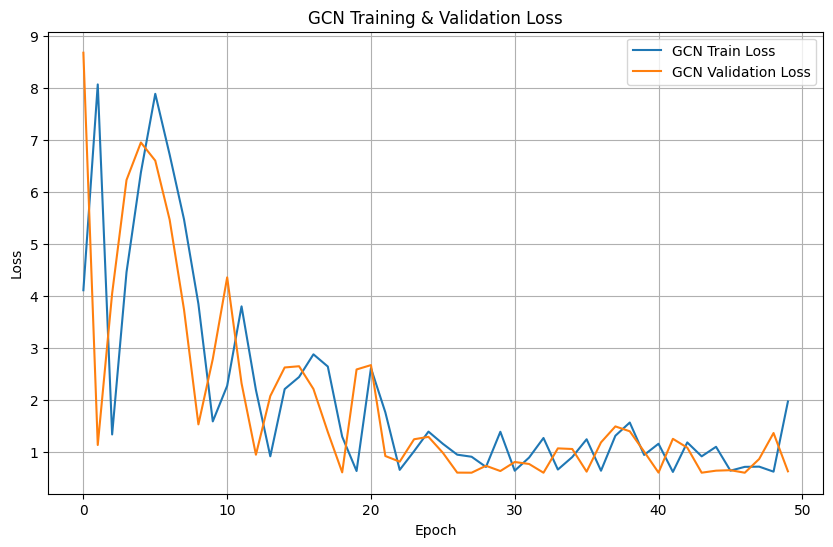

In [2]:
gcn_train_losses = np.load("gcn_train_losses.npy")
gcn_val_losses = np.load("gcn_val_losses.npy")

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(gcn_train_losses, label='GCN Train Loss')
plt.plot(gcn_val_losses, label='GCN Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GCN Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
#Baseline Metrics for CLassical model 

In [6]:
#Next Classical model for baseline 
#Best Next Classical Baseline: k-Means Clustering + Evaluation
# 1. Load Embeddings and Run k-Means


import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load embeddings from AE
embeddings = np.load("compressed_embeddings.npy")  # shape: (256, 16)

# Run k-means
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

# Evaluate clustering
sil_score = silhouette_score(embeddings, labels)
print(f"Silhouette Score (k-means on AE embeddings): {sil_score:.3f}")


Silhouette Score (k-means on AE embeddings): 0.744


c:\Users\synap\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


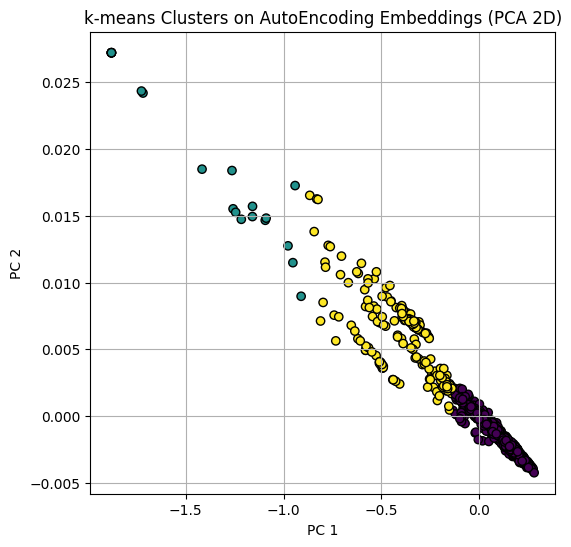

Silhouette Score: 0.744


In [8]:
#Visualize k-means clusters in 2D
# Reduce to 2D for plotting
pca = PCA(n_components=2)
proj = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(proj[:, 0], proj[:, 1], c=labels, cmap='viridis', edgecolors='k')
plt.title("k-means Clusters on AutoEncoding Embeddings (PCA 2D)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.show()
print(f"Silhouette Score: {sil_score:.3f}")


In [9]:
#PCA to justify embedding 
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(embeddings)
explained_var = np.sum(pca.explained_variance_ratio_)
print(f"PCA explained variance (2D): {explained_var:.2%}")


PCA explained variance (2D): 98.65%


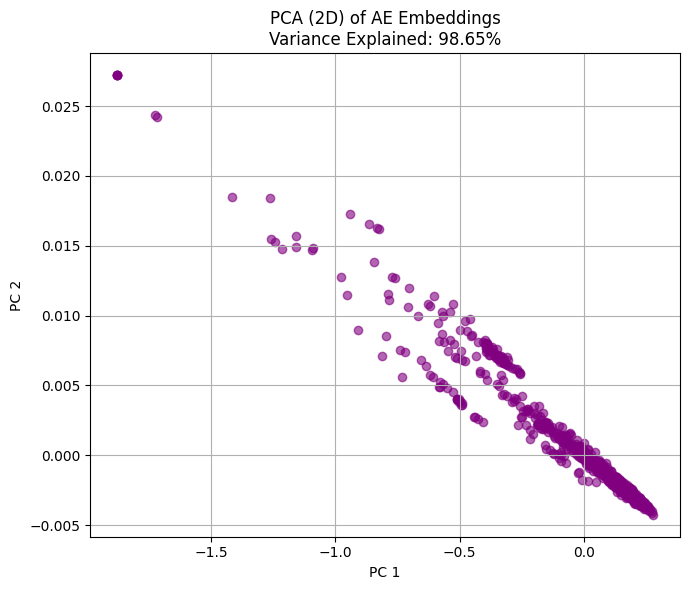

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

embeddings = np.load("compressed_embeddings.npy")

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

plt.figure(figsize=(7, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='purple', alpha=0.6)
plt.title(f"PCA (2D) of AE Embeddings\nVariance Explained: {np.sum(pca.explained_variance_ratio_):.2%}")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.tight_layout()
plt.show()
